In [1]:
import torch
from torch import nn
from utils.CustomAudioDataset_20230124 import CustomAudioDataset, LogSpectrogramExtractor, MinMaxNormalizer
from utils.VariationalAutoEncoder import VAE
from utils.train_test_dataset import train_test_dataset
from utils.extract_dataset import extract_dataset
from torch.utils.data import DataLoader
from torchaudio import transforms
import numpy as np
from matplotlib import pyplot as plt
import os
from pprint import pprint

In [2]:
duration = 3
audio_folder = 'barks_' + str(duration) + 's'
# FRAME_SIZE = 512
# HOP_LENGTH = 256
N_MELS=128
HOP_LENGTH=512
N_MFCC = 40

full_dataset = CustomAudioDataset(duration = duration, 
                                  extractor = LogSpectrogramExtractor(N_MELS, HOP_LENGTH),
                                  normalizer = MinMaxNormalizer(0, 1))

Annotations file already exists: /Users/pierpaolo.culurciello/python-venv/pytorch/DSSC_Deep_Learning/project/One-Class-Audio-Classifier/barks_3s.csv


In [3]:
barks_dataset = extract_dataset(duration, 
                                LogSpectrogramExtractor(N_MELS, HOP_LENGTH), 
                                MinMaxNormalizer(0, 1), 
                                'bark')
env_dataset = extract_dataset(duration,
                              LogSpectrogramExtractor(N_MELS, HOP_LENGTH), 
                              MinMaxNormalizer(0, 1), 
                              'bark', 
                              invert_match=True)

Annotations file already exists: /Users/pierpaolo.culurciello/python-venv/pytorch/DSSC_Deep_Learning/project/One-Class-Audio-Classifier/barks_3s.csv
Annotations file already exists: /Users/pierpaolo.culurciello/python-venv/pytorch/DSSC_Deep_Learning/project/One-Class-Audio-Classifier/barks_3s.csv


In [4]:
datasets = train_test_dataset(barks_dataset, test_split=0.3)
#print(len(datasets['train']))
#print(len(datasets['test']))
# The original dataset is available in the Subset class
#pprint(vars(full_dataset))

#dataloaders = {x:DataLoader(datasets[x],32, shuffle=True, num_workers=4) for x in ['train', 'test']}
#x,y = next(iter(dataloaders['train']))
#print(x.shape, y.shape)

In [5]:
# Defining the device

if (torch.backends.mps.is_available() and torch.backends.mps.is_built()):
    device = torch.device("mps")

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mps


In [6]:
## Define data loading step
import re
#num_workers = 4 if re.search("cuda", str(device)) else 0
# Sysdig MacBook Pro with Apple M1 Max 24 cores built-in GPU
#num_workers = 4 * 24 if re.search("mps", str(device)) else 0
# Found out that on Sysdig MacBook works much better with num_workers=0
num_workers = 0

batch_size = 64
train_loader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(datasets['test'], batch_size=batch_size, shuffle=True, num_workers=num_workers)
env_loader = DataLoader(env_dataset, batch_size=len(env_dataset), shuffle=True, num_workers=num_workers)

#print(len(train_loader.dataset))
#print(len(test_loader.dataset))

#for i_batch, sample_batched in enumerate(train_loader):
#    print(i_batch, sample_batched[0].shape)

In [7]:
logspec, _, _, _ , _ = next(iter(train_loader))

n_samples = logspec.shape[-1]    

print(logspec.shape)
print(N_MELS)
print(n_samples)

torch.Size([64, 1, 128, 130])
128
130


In [8]:
# input_shape=(1, N_MELS, n_samples)
# conv_filters=[512, 256, 256, 128, 128, 64, 64, 32, 32]
# conv_kernels=[3, 3, 3, 3, 3, 3, 3, 3, 3]
# conv_strides=[2, 2, 2, 2, 2, 2, 2, 2, 1]
# latent_space_dim=128

input_shape=(1, N_MELS, n_samples)
conv_filters=[512, 256, 128, 64, 32]
conv_kernels=[3, 3, 3, 3, 3]
conv_strides=[2, 2, 2, 2, 1]
latent_space_dim=128
    
model = VAE(input_shape,
              conv_filters,
              conv_kernels,
              conv_strides,
              latent_space_dim)

#print(model._get_encoder_layers())
#print(model._get_decoder_layers())

In [9]:
# Reconstruction + β * KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar, β=1):
    recon_loss_weight = 1e9

    Loss = nn.MSELoss()
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    
    print(f'MSELoss: {recon_loss_weight * Loss(x_hat, x)}')
    print(f'KLD: {β * KLD}')
    
    return recon_loss_weight * Loss(x_hat, x) + β * KLD

In [10]:
def reset_all_weights(model: nn.Module) -> None:
    """
    refs:
        - https://discuss.pytorch.org/t/how-to-re-set-alll-parameters-in-a-network/20819/6
        - https://stackoverflow.com/questions/63627997/reset-parameters-of-a-neural-network-in-pytorch
        - https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    """

    @torch.no_grad()
    def weight_reset(m: nn.Module):
        # - check if the current module has reset_parameters & if it's callable exec it on m
        reset_parameters = getattr(m, "reset_parameters", None)
        print(str(type(m)) + "reset_parameters")
        if callable(reset_parameters):
            m.reset_parameters()

    # Applies fn recursively to every submodule see: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    model.apply(fn=weight_reset)

In [11]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

encoder.conv1.weight tensor([[[[-0.2175, -0.2013,  0.2258],
          [-0.2544,  0.2992, -0.3132],
          [ 0.1271,  0.0658, -0.1801]]],


        [[[-0.2111, -0.2582,  0.1953],
          [ 0.0390, -0.0855,  0.2636],
          [-0.1381, -0.0861, -0.3082]]],


        [[[ 0.1041,  0.0927,  0.2491],
          [ 0.3185, -0.2936,  0.0664],
          [-0.2708,  0.1413, -0.0779]]],


        ...,


        [[[ 0.1008, -0.0811,  0.2267],
          [-0.1214, -0.3162,  0.1178],
          [-0.0758,  0.1823, -0.2180]]],


        [[[-0.2923,  0.2121,  0.0572],
          [-0.1621, -0.2253,  0.1650],
          [-0.0865, -0.2798,  0.0533]]],


        [[[ 0.3190,  0.0906, -0.3313],
          [-0.1051, -0.1483,  0.0386],
          [-0.3287,  0.0714, -0.0700]]]])
encoder.conv1.bias tensor([ 0.1341, -0.0244, -0.1808, -0.1940,  0.1667, -0.3238,  0.0553, -0.1267,
        -0.2690,  0.2863,  0.2996, -0.0200, -0.0554, -0.2092,  0.0061, -0.2644,
         0.2842, -0.3255,  0.0929, -0.1651,  0.0829,  0.0312

In [15]:
# Training and testing the VAE

epochs = 150
codes = dict(μ=list(), logσ2=list(), y=list())

# EARLY STOPPING: stop when GL_alpha > alpha
alpha = 30
GL_alpha = 0.

# EARLY STOPPING: stop when avg(E_tr) is less than 10% higher than min(E_tr)(P_kappa < 100):
kappa=5
P_kappa = 1000
E_tr_arr = []

model.to(device)
#reset_all_weights(model)
#model._init_weights()
model._reset_params()
model.zero_grad()


# Setting the optimiser

learning_rate = 1e-2
weight_decay = 5e-4
momentum = 0.9

#optimizer = torch.optim.SGD(model.parameters(), 
#                            lr=learning_rate, 
#                            weight_decay=weight_decay)

# optimizer = torch.optim.SGD(model.parameters(), 
#                       lr=learning_rate, 
#                       momentum=momentum,
#                       weight_decay=weight_decay)

optimizer = torch.optim.Adam(model.parameters(),
                            lr=learning_rate,
                            weight_decay=weight_decay)

for epoch in range(0, epochs + 1):
    
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _, _, _, _ in train_loader:
            x = x.to(device)          
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            if epoch % 10 == 0:
                print('logvar: shape: ' + str(logvar.shape) + 
                      ' mean: ' + str(torch.mean(logvar).item()) +
                      ' std: ' + str(torch.std(logvar).item()))
                print('mu: shape: ' + str(mu.shape) +  
                      ' mean: ' + str(torch.mean(mu).item()) +
                      ' std: ' + str(torch.std(mu).item()))
                print('x: shape: ' + str(x.shape) +  
                      ' mean: ' + str(torch.mean(x).item()) +
                      ' std: ' + str(torch.std(x).item()))
                print('x_hat: shape: ' + str(x_hat.shape) + 
                      ' mean: ' + str(torch.mean(x_hat).item()) +
                      ' std: ' + str(torch.std(x_hat).item()))
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
        E_tr_arr.append(train_loss)
        
    # Testing
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, _, _, y, _ in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            if epoch % 10 == 0:
                print('logvar: shape: ' + str(logvar.shape) + 
                      ' mean: ' + str(torch.mean(logvar).item()) +
                      ' std: ' + str(torch.std(logvar).item()))
                print('mu: shape: ' + str(mu.shape) +  
                      ' mean: ' + str(torch.mean(mu).item()) +
                      ' std: ' + str(torch.std(mu).item()))
                print('x: shape: ' + str(x.shape) +  
                      ' mean: ' + str(torch.mean(x).item()) +
                      ' std: ' + str(torch.std(x).item()))
                print('x_hat: shape: ' + str(x_hat.shape) + 
                      ' mean: ' + str(torch.mean(x_hat).item()) +
                      ' std: ' + str(torch.std(x_hat).item()))
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')

    if epoch == 0:
      E_opt = test_loss 
    else:
      if test_loss < E_opt: E_opt = test_loss
    
    GL_alpha = 100 * (test_loss/E_opt -1)

    if epoch >= kappa:
      E_tr_slice = E_tr_arr[epoch - kappa:]
      E_tr_avg = sum(E_tr_slice) / len(E_tr_slice) 
      E_tr_min = min(E_tr_slice)
      P_kappa = 1000 * (E_tr_avg/E_tr_min -1)
      print("GL_alpha = " + str(GL_alpha))
      print("P_kappa = " + str(P_kappa))
      print("E_tr_avg = " + str(E_tr_avg))
      print("E_tr_min = " + str(E_tr_min))
      if (GL_alpha > alpha and P_kappa < 100) or (E_tr_avg < 1.1 * E_tr_min):
        break

logvar: shape: torch.Size([64, 128]) mean: -0.00038978271186351776 std: 0.015962673351168633
mu: shape: torch.Size([64, 128]) mean: -0.0020042965188622475 std: 0.01756478287279606
x: shape: torch.Size([64, 1, 128, 130]) mean: 0.2554866373538971 std: 0.19471824169158936
x_hat: shape: torch.Size([64, 1, 128, 130]) mean: 0.3013048470020294 std: 0.018319670110940933
MSELoss: 40319448.0
KLD: 1.8016332387924194
logvar: shape: torch.Size([64, 128]) mean: -0.0003844930906780064 std: 0.01597111113369465
mu: shape: torch.Size([64, 128]) mean: -0.0020016832277178764 std: 0.017579246312379837
x: shape: torch.Size([64, 1, 128, 130]) mean: 0.26955944299697876 std: 0.1945600062608719
x_hat: shape: torch.Size([64, 1, 128, 130]) mean: 0.3013048470020294 std: 0.018319670110940933
MSELoss: 39171096.0
KLD: 1.8042223453521729
logvar: shape: torch.Size([64, 128]) mean: -0.00038448578561656177 std: 0.015963459387421608
mu: shape: torch.Size([64, 128]) mean: -0.0020027514547109604 std: 0.0175778828561306
x: s

MSELoss: 50268520.0
KLD: 8077.69921875
MSELoss: 46951016.0
KLD: 8224.4091796875
MSELoss: 46665112.0
KLD: 8175.6474609375
MSELoss: 46083900.0
KLD: 8200.1865234375
MSELoss: 41271904.0
KLD: 8176.57080078125
MSELoss: 40849880.0
KLD: 8199.9306640625
MSELoss: 38782648.0
KLD: 7565.8046875
====> Epoch: 9 Average loss: 741261.4677
MSELoss: 32782306.0
KLD: 9164.021484375
MSELoss: 30269452.0
KLD: 7634.22021484375
MSELoss: 31903084.0
KLD: 8020.17724609375
MSELoss: 30253436.0
KLD: 7886.6201171875
MSELoss: 30746278.0
KLD: 1934.2320556640625
====> Test set loss: 571388.9890
GL_alpha = 0.0
P_kappa = 1467.6907850926489
E_tr_avg = 1161544599.2
E_tr_min = 470701032.0
logvar: shape: torch.Size([64, 128]) mean: -0.2986108064651489 std: 0.8330049514770508
mu: shape: torch.Size([64, 128]) mean: -4.386017099022865e-05 std: 1.2952570915222168
x: shape: torch.Size([64, 1, 128, 130]) mean: 0.24641524255275726 std: 0.1909952163696289
x_hat: shape: torch.Size([64, 1, 128, 130]) mean: 0.2571069896221161 std: 0.3253

MSELoss: 14573620.0
KLD: 8704.57421875
MSELoss: 13718684.0
KLD: 8708.4267578125
MSELoss: 14930889.0
KLD: 8760.48046875
MSELoss: 13322536.0
KLD: 8756.7802734375
MSELoss: 12705532.0
KLD: 8784.111328125
MSELoss: 13064749.0
KLD: 8812.751953125
MSELoss: 13289798.0
KLD: 8799.103515625
MSELoss: 12148341.0
KLD: 8817.81640625
MSELoss: 12275834.0
KLD: 8837.30859375
MSELoss: 12360949.0
KLD: 8146.1943359375
====> Epoch: 13 Average loss: 208626.8646
MSELoss: 10406672.0
KLD: 9290.2265625
MSELoss: 10062827.0
KLD: 8534.193359375
MSELoss: 10605927.0
KLD: 8371.5595703125
MSELoss: 10654847.0
KLD: 8231.01953125
MSELoss: 10930223.0
KLD: 2401.78369140625
====> Test set loss: 193030.4945
GL_alpha = 0.0
P_kappa = 998.7317582906314
E_tr_avg = 264788103.8
E_tr_min = 132478059.0
MSELoss: 11532271.0
KLD: 8864.4169921875
MSELoss: 11913340.0
KLD: 8855.18359375
MSELoss: 12112778.0
KLD: 8869.10546875
MSELoss: 11609138.0
KLD: 8887.521484375
MSELoss: 10804479.0
KLD: 8887.318359375
MSELoss: 11002416.0
KLD: 8918.92285156

In [16]:
FILENAME = audio_folder + '.pth'
PATH = os.path.join(os.getcwd(), "saved_models/" + FILENAME)

print(PATH)

# Save model
torch.save(model.state_dict(), PATH)

# Load model
model = VAE(input_shape,
              conv_filters,
              conv_kernels,
              conv_strides,
              latent_space_dim)
model.load_state_dict(torch.load(PATH))
model.to(device)
model.eval()

# # for name, param in model.named_parameters():
# #     if param.requires_grad:
# #         print(name, param.data)

/Users/pierpaolo.culurciello/python-venv/pytorch/DSSC_Deep_Learning/project/One-Class-Audio-Classifier/saved_models/barks_3s.pth


VAE(
  (encoder): Sequential(
    (conv1): Conv2d(1, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu1): ReLU()
    (batchnorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu2): ReLU()
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu3): ReLU()
    (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu4): ReLU()
    (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu5): ReLU()
    (batchnorm5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
# # function that splits an audio file of arbitrary length in chunks of length 'lenght':
# import soundfile as sf

# def cut_audio_file(file_name, length, output_folder):
#     # First load the file
#     audio, sr = librosa.load(file_name)

#     # Get number of samples for length seconds
#     buffer = length * sr

#     samples_total = len(audio)
#     samples_wrote = 0
#     counter = 1

#     while samples_wrote < samples_total:

#         #check if the buffer is not exceeding total samples 
#         if buffer > (samples_total - samples_wrote):
#             buffer = samples_total - samples_wrote

#         block = audio[samples_wrote : (samples_wrote + buffer)]
#         out_filename = "split_" + str(counter) + "_" + file_name

#         # Write 'length' second segment
#         out_file_path = os.path.join(output_folder, out_filename)
#         sf.write(out_file_path, block, samplerate=sr)
#         counter += 1
#         samples_wrote += buffer

In [17]:
import librosa
import soundfile as sf

output_folder = os.getcwd() + '/fakes'

In [18]:
def logspec_to_audio(logspec, hop_length):
    # reshape the log spectrogram
    logspec = logspec[0, 0, :, :]
    # log spectrogram -> spectrogram
    spec = librosa.db_to_power(logspec, ref=1.0)
    # from melspec to audio
    signal = librosa.feature.inverse.mel_to_audio(spec, hop_length=hop_length)
    
    return signal

In [19]:
import math

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

def print_logspec(logspec):
    print(namestr(logspec, globals()) + ': shape: ' + str(list(logspec.shape)) +  
          ' mean: ' + str(torch.mean(logspec).item()) +
          ' std: ' + str(torch.std(logspec).item()))  
    
def plot_audio(folder, filename, audio_samples, sample_rate):
    wav_path = os.path.join(folder, filename)
    # write audio time samples
    sf.write(wav_path, audio_samples, samplerate=sample_rate)
    # plot
    AudioTensor.create(wav_path).show()

    
def plot_logspec(logspec_array):
    N = logspec_array.shape[0]
    dim = math.ceil(np.sqrt(N))
    
    vmin = np.min(np.array(logspec_array))
    vmax = np.max(np.array(logspec_array))

    fig = plt.figure()

    i = 1
    for logspec in logspec_array:
        logspec = logspec[0, :, :]
        ax = fig.add_subplot(dim,dim,i)
        mesh = ax.pcolormesh(logspec)
        mesh.set_clim(vmin,vmax)
        # Visualizing colorbar part -start
        fig.colorbar(mesh,ax=ax)
        fig.tight_layout()
        # Visualizing colorbar part -end
        i += 1 

sample_logspec_norm: shape: [1, 1, 128, 130] mean: 0.2628001868724823 std: 0.2155555933713913
sample_logspec: shape: [1, 1, 128, 130] mean: -34.887184143066406 std: 17.244447708129883
x_hat_norm: shape: [1, 1, 128, 130] mean: 0.25606971979141235 std: 0.17261764407157898
x_hat: shape: [1, 1, 128, 130] mean: -35.425628662109375 std: 13.80941104888916
MSE Loss: tensor(70.1357)


/opt/homebrew/lib/python3.10/site-packages/fastaudio/core/signal.py:85: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:354.)
  display(Audio(self.cpu(), rate=self.sr))


/opt/homebrew/lib/python3.10/site-packages/torch/_tensor.py:915: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:354.)
  if self.dim() == 0:
/opt/homebrew/lib/python3.10/site-packages/torch/_tensor.py:926: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:354.)
  return iter(self.unbind(0))
/opt/homebrew/lib/python3.10/site-packages/fastaudio/core/signal.py:77: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/

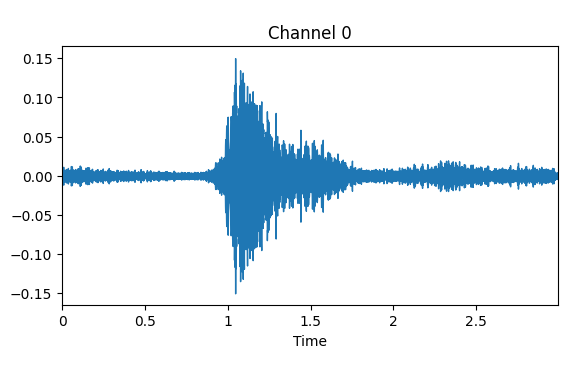

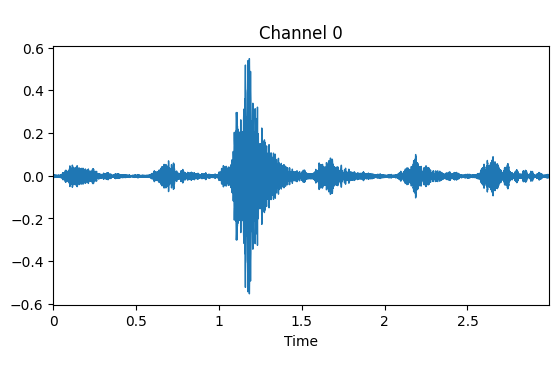

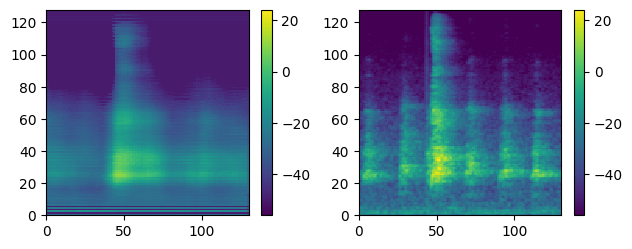

In [20]:
from fastaudio.core.all import *

# EXPERIMENT 1: Get a batch sample from test dataset
logspecs, min_values, max_values, class_id, class_name = next(iter(test_loader))

# Get a random index between 0 and batch_size
random_index = int(np.random.random()*test_loader.batch_size)
# print(random_index)

sample_logspec_norm = logspecs[random_index].unsqueeze(0).cpu().detach()

min_val = min_values[random_index].numpy()
max_val = max_values[random_index].numpy()

# print("min_val: " + str(min_val))
# print("max_val: " + str(max_val))

print_logspec(sample_logspec_norm)

normalizer = MinMaxNormalizer(0, 1)
sr = 22050

# denormalize
sample_logspec = normalizer.denormalize(sample_logspec_norm, min_val, max_val)

print_logspec(sample_logspec)

sample_audio = logspec_to_audio(sample_logspec.numpy(), HOP_LENGTH)

mu_logvar = model.encoder(sample_logspec_norm.to(device)).view(-1, 2, model.latent_space_dim)
z = mu_logvar[:, 0, :]
x_hat_norm = model.decoder(z).cpu().detach()

print_logspec(x_hat_norm)

# denormalize
x_hat = normalizer.denormalize(x_hat_norm, min_val, max_val)

print_logspec(x_hat)

loss = nn.MSELoss()
print("MSE Loss: " + str(loss(x_hat, sample_logspec)))

x_hat_audio = logspec_to_audio(x_hat.numpy(), HOP_LENGTH)

# plot decoded audio
plot_audio(output_folder, 'decoded_test_bark.wav', x_hat_audio, sr)

# plot original audio
plot_audio(output_folder, 'original_test_bark.wav', sample_audio, sr)

logspec_array = np.vstack([x_hat.numpy(), sample_logspec.numpy()])

# Plot log spectrograms
plot_logspec(logspec_array)

sample_logspec_norm: shape: [1, 1, 128, 130] mean: 0.2518501877784729 std: 0.19702090322971344
sample_logspec: shape: [1, 1, 128, 130] mean: -25.100399017333984 std: 15.761672973632812
x_hat_norm: shape: [1, 1, 128, 130] mean: 0.24747027456760406 std: 0.15585379302501678
x_hat: shape: [1, 1, 128, 130] mean: -25.450788497924805 std: 12.468302726745605
MSE Loss: tensor(107.1937)


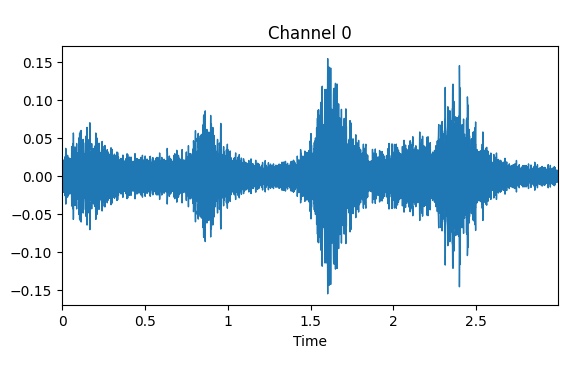

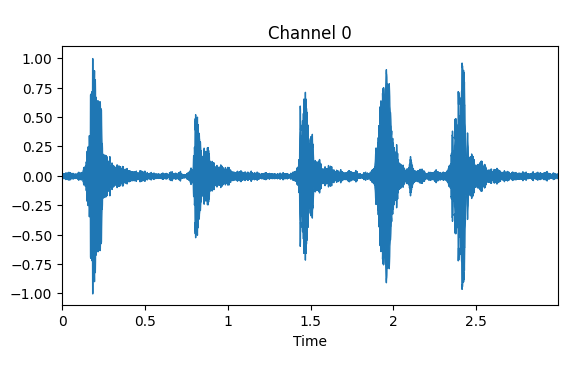

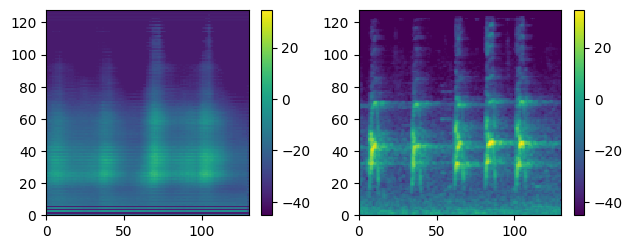

In [21]:
# EXPERIMENT 2: try with a completely different class of sound:
logspecs, min_values, max_values, class_id, class_name = next(iter(env_loader))

# Get a random index between 0 and batch_size
random_index = int(np.random.random()*env_loader.batch_size)
# print(random_index)

sample_logspec_norm = logspecs[random_index].unsqueeze(0).cpu().detach()

min_val = min_values[random_index].numpy()
max_val = max_values[random_index].numpy()

# print("min_val: " + str(min_val))
# print("max_val: " + str(max_val))

print_logspec(sample_logspec_norm)

normalizer = MinMaxNormalizer(0, 1)
sr = 22050

# denormalize
sample_logspec = normalizer.denormalize(sample_logspec_norm, min_val, max_val)

print_logspec(sample_logspec)

sample_audio = logspec_to_audio(sample_logspec.numpy(), HOP_LENGTH)

mu_logvar = model.encoder(sample_logspec_norm.to(device)).view(-1, 2, model.latent_space_dim)
z = mu_logvar[:, 0, :]
x_hat_norm = model.decoder(z).cpu().detach()

print_logspec(x_hat_norm)

# denormalize
x_hat = normalizer.denormalize(x_hat_norm, min_val, max_val)

print_logspec(x_hat)

loss = nn.MSELoss()
print("MSE Loss: " + str(loss(x_hat, sample_logspec)))

x_hat_audio = logspec_to_audio(x_hat.numpy(), HOP_LENGTH)

# plot decoded audio
plot_audio(output_folder, 'decoded_env_sound.wav', x_hat_audio, sr)

# plot original audio
plot_audio(output_folder, 'original_env_sound.wav', sample_audio, sr)

logspec_array = np.vstack([x_hat.numpy(), sample_logspec.numpy()])

# Plot log spectrograms
plot_logspec(logspec_array)

In [28]:
# mu_logvar contains the encoder output (in the latent space) for the len(barks_dataset) samples
# compute the mean and std for each latent space dimension
# use these mean and std to generate latent space points with a Normal distribution
train_loader_dataset = train_loader.dataset.dataset.audio_ds
train_loader_indices = train_loader.dataset.indices
train_dataset = train_loader_dataset.loc[train_loader_dataset.index[train_loader_indices]]

mu_logvar = torch.empty((len(train_dataset), 2, model.latent_space_dim)).to(device)

i = 0
for logspec in train_dataset['logspec']:
    logspec = torch.tensor(logspec[np.newaxis, np.newaxis, :, :])
    mu_logvar[i, :, :] = model.encoder(logspec.to(device)).view(-1, 2, model.latent_space_dim)
    i += 1
    
# z = mu_logvar[:, 0, :]
# logvar = mu_logvar[:, 1, :]

In [29]:
# find the probability distribution with params that best fit the empirical distribution 
# of the len(train_dataset) samples for each latent space dimension

import scipy.stats as st

def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "beta", "gamma", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        #print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

#     print("Best fitting distribution: "+str(best_dist))
#     print("Best p value: "+ str(best_p))
#     print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

def get_random_variate(dist_name, dist_params, size):
    # Separate parts of parameters
    arg = dist_params[:-2]
    loc = dist_params[-2]
    scale = dist_params[-1]
    
    dist = getattr(st, dist_name)
    
    match dist_name:
        case "exponweib":
            random_variate = dist.rvs(a=arg[0], c=arg[1], loc=loc, scale=scale, size=size)
        case "norm":
            random_variate = dist.rvs(loc=loc, scale=scale, size=size)
        case "beta":
            random_variate = dist.rvs(a=arg[0], b=arg[1], loc=loc, scale=scale, size=size)
        case "genextreme" | "weibull_min" | "weibull_max" | "gamma":
            random_variate = dist.rvs(arg, loc=loc, scale=scale, size=size)
        
    return torch.tensor(random_variate)

In [30]:
best_dists = [{'dist_name': None, 'dist_params': None} for x in range( model.latent_space_dim)]
for i in range(mu_logvar[:, 0, :].shape[-1]):
    best_dist, best_p, params = get_best_distribution(mu_logvar[:, 0, i].cpu().detach())
    best_dists[i]['dist_name'] = best_dist
    best_dists[i]['dist_params'] = params

/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


(1, 128, 130)


(1, 128, 130)


(1, 128, 130)


(1, 128, 130)


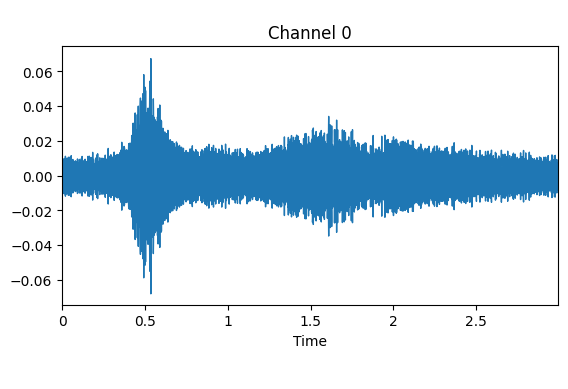

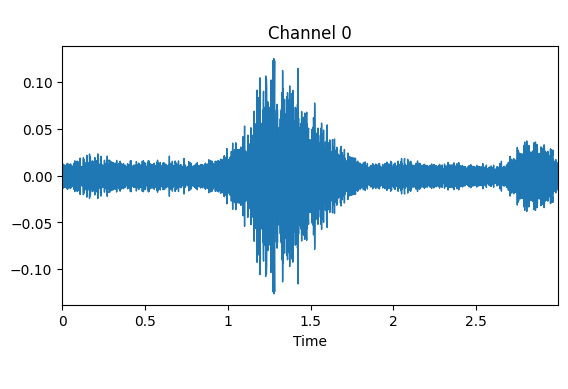

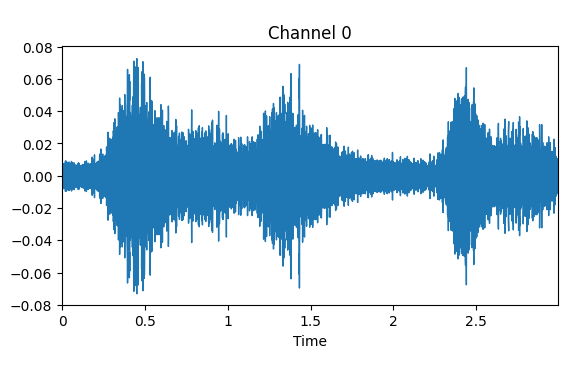

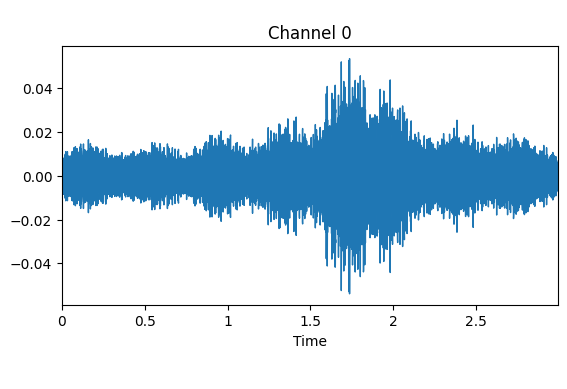

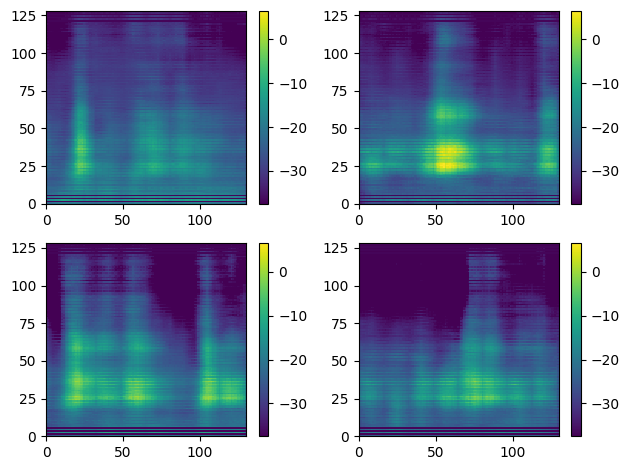

In [31]:
# EXPERIMENT 3: generate samples from latent space (after encoder) and decode them

from fastaudio.core.all import *

# parameters
sr = 22050

# Get a random index between 0 and train_dataset size and uset it
# to select logspec min and max values for a train dataset sample for decoder output normalization
random_index = int(np.random.random() * len(train_dataset))

logspec_min = train_dataset['min'][random_index]
logspec_max = train_dataset['max'][random_index]

# # Get the mean of both logspec min and max values and use to normalize the decoder output
# logspec_min = np.mean(train_dataset['min'].to_numpy())
# logspec_max = np.mean(train_dataset['max'].to_numpy())

normalizer = MinMaxNormalizer(0, 1)

# Generating a few samples using the computed mean and std for each latent space dimension
N = 4
z = torch.empty(N, model.latent_space_dim).to(device)

# for i in range(N):
#     z[i, :] = torch.normal(torch.mean(mu_logvar[:, 0, :], dim=0), 
#                  torch.std(mu_logvar[:, 0, :], dim=0).exp_()).unsqueeze(0)

for i in range(model.latent_space_dim):
    z[:, i] = get_random_variate(best_dists[i]['dist_name'], best_dists[i]['dist_params'], N)
    
# for j in range(N):
#     print(z[j, :])

fakes = model.decoder(z).cpu().detach().numpy() 

fakes_denorm = normalizer.denormalize(fakes, logspec_min, logspec_max)

# plot audio
i = 1
for fake in fakes_denorm:
    fake_audio = logspec_to_audio(fake[np.newaxis, :, :, :], HOP_LENGTH)
    # write audio time samples
    fake_bark_filename = "fake_bark_" + str(i) + ".wav"
    fake_bark_path = os.path.join(output_folder, fake_bark_filename)
    sf.write(fake_bark_path, fake_audio, samplerate=sr)
    AudioTensor.create(fake_bark_path).show()

# Plot log spectrograms
plot_logspec(fakes_denorm)

In [62]:
# computes the reconstuction loss (RL) and the Kullback Leibler loss part of the VAE (KL) 
# for an audio dataset loader object
def compute_RL_KL(audio_dataset):
    RL = []
    KL = []
    labels = []
    
    i = 0
    for (logspec_norm, min_val, max_val, class_name) in zip(audio_dataset['logspec'],
                                                audio_dataset['min'],
                                                audio_dataset['max'],
                                                audio_dataset['class_name']):
    
        # denormalize logspec
        logspec = normalizer.denormalize(logspec_norm, min_val, max_val)

        #encode
        mu_logvar = model.encoder(torch.tensor(logspec_norm).unsqueeze(0).unsqueeze(0).to(device))
        mu_logvar = mu_logvar.view(-1, 2, model.latent_space_dim)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]

        #decode
        x_hat_norm = model.decoder(mu).cpu().detach()

        # denormalize decoded logspec
        x_hat = normalizer.denormalize(x_hat_norm, min_val, max_val)

        Recon_Loss = nn.MSELoss()
        RL.append(Recon_Loss(x_hat, torch.tensor(logspec)))
        KL.append(0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2)))
        labels.append(class_name)
        i += 1
        
    KL = torch.tensor(KL).cpu().detach().numpy()
    RL = torch.tensor(RL).cpu().detach().numpy()
    
    return RL, KL, labels

In [104]:
import pandas as pd

test_dataset = test_loader.dataset.dataset.audio_ds.loc[test_loader.dataset.indices]

RL_test_bark, KL_test_bark, bark_labels= compute_RL_KL(test_dataset)
RL_test_env, KL_test_env, env_labels = compute_RL_KL(env_dataset.audio_ds)


test_bark_data = {"RL": RL_test_bark,
                  "KL": KL_test_bark,
                  "class": bark_labels}

test_bark_ds = pd.DataFrame(test_bark_data)

test_env_data = {"RL": RL_test_env,
                  "KL": KL_test_env,
                  "class": env_labels}

test_env_ds = pd.DataFrame(test_env_data)

test_ds = test_bark_ds.append(test_env_ds, ignore_index=True)
test_ds = test_ds.dropna().reset_index(drop=True)

/opt/homebrew/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([128, 130])) that is different to the input size (torch.Size([1, 1, 128, 130])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/var/folders/tt/c1w5rnl91l3bvv13d_l1jgrm0000gp/T/ipykernel_38649/1558390665.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_ds = test_bark_ds.append(test_env_ds, ignore_index=True)


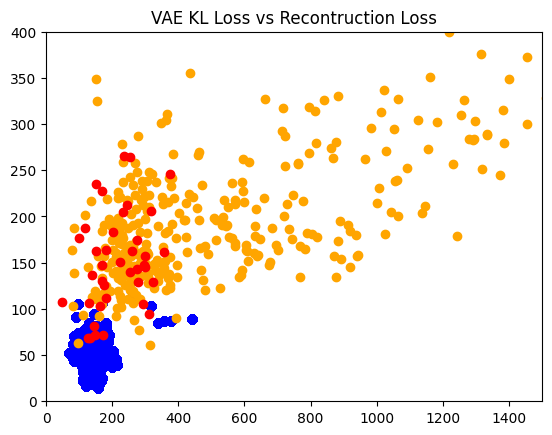

In [105]:
plt.figure(1)
plt.title("VAE KL Loss vs Recontruction Loss")

for i in range(len(test_ds)):
    match test_ds["class"][i]:
        case "bark":
            plt.scatter(KL_test_bark, RL_test_bark, color = 'blue')
        case "dog_bark":
            plt.scatter(test_ds["KL"][i], test_ds["RL"][i], color = 'red')
        case _:
            plt.scatter(test_ds["KL"][i], test_ds["RL"][i], color = 'orange')
        
plt.xlim([0, 1500])
plt.ylim([0, 400])
plt.show()

In [106]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

X = test_ds[['RL', 'KL']]  # Features
y = (test_ds['class'] == 'bark').astype(np.int)  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

/var/folders/tt/c1w5rnl91l3bvv13d_l1jgrm0000gp/T/ipykernel_38649/2946071910.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (test_ds['class'] == 'bark').astype(np.int)  # Labels


In [110]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [111]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9801980198019802


In [ ]:
# Audio recostruction test using spectrograms

def logspec_to_audio(logspec, hop_length):
    # reshape the log spectrogram
    logspec = logspec[0, 0, :, :]
    # log spectrogram -> spectrogram
    spec = librosa.db_to_amplitude(logspec)
    # apply Griffin-Lim
    signal = librosa.istft(spec, hop_length=hop_length)
    return signal

def plot_audio(folder, filename, audio_samples, sample_rate):
    wav_path = os.path.join(folder, filename)
    # write audio time samples
    sf.write(wav_path, audio_samples, samplerate=sample_rate)
    # plot
    AudioTensor.create(wav_path).show()
    
log_spec_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
min_max_normalizer = MinMaxNormalizer(0, 1)

file_name = 'barks_01.wav'
audio_dir = 'barks_2s'

audio_path = os.path.join(os.getcwd(), audio_dir)
file_path = os.path.join(audio_path, file_name)

audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
plot_audio(audio_path, file_name, audio, sample_rate)
audio_tensor = torch.tensor(audio)
print_logspec(audio_tensor)

logspec = log_spec_extractor.extract(audio)
logspec_tensor = torch.tensor(logspec)
print_logspec(logspec_tensor)

logspec_norm = min_max_normalizer.normalize(logspec)
logspec_norm_tensor = torch.tensor(logspec_norm)
print_logspec(logspec_norm_tensor)

logspec = min_max_normalizer.denormalize(logspec_norm, logspec.min(), logspec.max())
logspec_tensor = torch.tensor(logspec)
print_logspec(logspec_tensor)

audio = logspec_to_audio(logspec_tensor.unsqueeze(0).unsqueeze(0).numpy(), HOP_LENGTH)
plot_audio(os.path.join(os.getcwd(), 'fakes'), 'barks_01.wav', audio, sample_rate)
audio_tensor = torch.tensor(audio)
print_logspec(audio_tensor)

In [ ]:
# Audio recostruction test using melspectrograms

def plot_audio(folder, filename, audio_samples, sample_rate):
    wav_path = os.path.join(folder, filename)
    # write audio time samples
    sf.write(wav_path, audio_samples, samplerate=sample_rate)
    # plot
    AudioTensor.create(wav_path).show()

min_max_normalizer = MinMaxNormalizer(0, 1)

file_name = 'barks_01.wav'
audio_dir = 'barks_2s'
N_FFT = 2048 
HOP_LENGTH = 512 
N_MFCC = 128

audio_path = os.path.join(os.getcwd(), audio_dir)
file_path = os.path.join(audio_path, file_name)

audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
plot_audio(audio_path, file_name, audio, sample_rate)
audio_tensor = torch.tensor(audio)
print_logspec(audio_tensor)

#melspec = librosa.feature.melspectrogram(audio, n_fft=N_FFT, hop_length=HOP_LENGTH, sr=sample_rate)
melspec = librosa.feature.mfcc_to_audio(audio, n_mfcc=N_MFCC, sr=sample_rate)
melspec_tensor = torch.tensor(melspec)
print_logspec(melspec_tensor)

melspec_norm = min_max_normalizer.normalize(melspec)
melspec_norm_tensor = torch.tensor(melspec_norm)
print_logspec(melspec_norm_tensor)

melspec = min_max_normalizer.denormalize(melspec_norm, melspec.min(), melspec.max())
melspec_tensor = torch.tensor(melspec)
print_logspec(melspec_tensor)

#audio = librosa.feature.inverse.mel_to_audio(melspec, n_fft=N_FFT, hop_length=HOP_LENGTH, sr=sample_rate)
audio = librosa.feature.inverse.mfcc_to_audio(melspec, sr=sample_rate)
plot_audio(os.path.join(os.getcwd(), 'fakes'), 'barks_01.wav', audio, sample_rate)
audio_tensor = torch.tensor(audio)
print_logspec(audio_tensor)

## Test - Add melspectrogram to Pandas DataFrame

In [ ]:
import pandas as pd
import librosa
from utils.write_csv import write_csv

barks_folder = 'barks_1s'

# generate annotation CSV file
write_csv(barks_folder, barks_folder + '.csv')

annotation_file = os.path.join(os.getcwd(), barks_folder + '.csv')
audio_dir = os.path.join(os.getcwd(), barks_folder)

audio_ds = pd.read_csv(annotation_file)

In [ ]:
xs = [None] * len(audio_ds)
audio_ds['melspec'] = xs

for idx in range(len(audio_ds)):
    audio_path = os.path.join(audio_dir, audio_ds.iloc[idx]['file_name'])
    audio, sample_rate = librosa.load(audio_path, res_type='kaiser_fast')
    melspec = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    audio_ds['melspec'][idx] = melspec

In [ ]:
# save dataframe
audio_ds.to_pickle(barks_folder + ".pkl")

In [ ]:
import numpy as np

#n_freq = audio_ds['melspec'][0].shape[0]
#n_samples = audio_ds['melspec'][0].shape[1]
#audio_np = np.empty((len(audio_ds), n_freq, n_samples))
audio_np = np.array([])
for idx in range(len(audio_ds)):
    audio_np = np.append(audio_np, audio_ds['melspec'][idx])
    #audio_np.append(audio_ds['melspec'][idx])

In [ ]:
print(np.mean(audio_np))
print(np.std(audio_np))

In [ ]:
from os.path import exists

if exists(os.path.join(os.getcwd(), barks_folder + '.pkl')):
          print("esiste!")

In [ ]:
file_path = os.path.join(os.getcwd(), "ESC-10/001-dog_bark")
file_name = "3-163459-A.ogg"

audio, sample_rate = librosa.load(os.path.join(file_path, file_name), res_type='kaiser_fast')
AudioTensor.create(os.path.join(file_path, file_name)).show()

In [ ]:
import os
prefixed = [dirname for dirname in os.listdir('ESC-10') if not dirname.startswith("barks") and
                                                           not dirname.startswith(".")]

In [ ]:
print(prefixed)

In [ ]:
audio_path = os.path.join(os.getcwd(), 'ESC-10/baby_cry', '2-107351-A.ogg')
duration = 2
audio, sample_rate = librosa.load(audio_path, res_type='kaiser_fast')
tot_duration = round(len(audio) / sample_rate)
frame_start = round((tot_duration - duration) / 2 * sample_rate)
frame_end = frame_start + duration * sample_rate
feature = log_spec_extractor.extract(audio[frame_start:frame_end])
print(feature.shape)
print(tot_duration)
print(frame_start)
print(frame_end)

In [ ]:
# code to visualize bark files in order to complete manually the selection
import re

duration = 3
audio_folder = 'barks_' + str(duration) + 's'
barks_path = os.path.join(os.getcwd(), audio_folder)

file_count = 0
for file in os.listdir(barks_path):
    audio_path = os.path.join(barks_path, file)
    # get number of audio files in dir
    if os.path.isfile(audio_path) and re.search("barks", str(file)):
        file_count += 1

dim = math.ceil(np.sqrt(file_count))

columns = 10
rows = math.ceil(file_count / columns)

fig = plt.figure(figsize=(30,30))

i = 1
for file in os.listdir(barks_path):
    audio_path = os.path.join(barks_path, file)
    if os.path.isfile(audio_path) and re.search("barks", str(file)):
        audio, sr = librosa.load(audio_path, res_type='kaiser_fast')
        ax = fig.add_subplot(rows,columns,i)
        ax.plot(audio)
        ax.title.set_text(file)
        i += 1

In [ ]:
duration = 3
file_dir = 'barks_' + str(duration) + 's'

for num in [220, 214, 229, 156, 350, 184, 144, 384, 321, 253, 333, 305, 196, 225, 230, 226, 313, 361]:
    file_name = 'barks_' + str(num) + '.wav' if num > 10 else 'barks_0' + str(num) + '.wav'
    file_path = os.path.join(os.getcwd(), file_dir, file_name)
    if os.path.exists(file_path):
        os.remove(file_path)
        print('file ' + file_name + ' removed!')
    else:
        print('File ' + file_name + ' does not exist')